# Real Estate Label Classification model

In this notebbok we trained a resnet model to classify real estate images using fastai libraries.

resnet34 model performs with a accuracy of 97%
resnet50 model performs with a accuracy of 98%

Interpretation and Confusion Matrix is also plotted below.

# Import libraries


In [1]:
from fastai import*
from fastai.widgets import *
from fastai.vision import *
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import torch
import os
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
#specify dataset path 
path = Path('data/train')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path

PosixPath('data/train')

In [3]:
testpath = Path('data/test')

# Split Data with 20% random hold, label wise for test

classes= ['bedroom','bathroom','livingroom','kitchen','diningroom','interior','exterior']
test = Path('data/test')

for i in classes:
    
    master = Path('data/master/datasets/'+i)
    train = Path('data/train/'+i)
    
    # dir is your directory path
    masterfiles = os.listdir(master) 

    # randomize images
    random.seed(230)
    # shuffle images
    random.shuffle(masterfiles)

    # split train/test in 80/20
    split = int(0.8 * len(masterfiles))
    train_image = masterfiles[:split]
    test_image = masterfiles[split:]

    #move the files
    count = 0
    for f in masterfiles:
        if (f in test_image):
            count+=1
            shutil.move(os.path.join(master, f), os.path.join(test))
            os.rename(os.path.join(test, f), os.path.join(test, str(count)+str(int(time.time()))+f.rsplit('.', 1)[0] +".jpg"))
        elif (f in train_image):
            shutil.move(os.path.join(master, f), os.path.join(train))



# Navigate to images

# View data

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.',valid_pct=0.2, bs=128,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [5]:
data.sanity_check

<bound method DataBunch.sanity_check of ImageDataBunch;

Train: LabelList
y: CategoryList (94160 items)
[Category bathroom, Category bathroom, Category bathroom, Category bathroom, Category bathroom]...
Path: data/train
x: ImageItemList (94160 items)
[Image (3, 256, 256), Image (3, 1000, 1000), Image (3, 1000, 1000), Image (3, 1000, 1000), Image (3, 256, 256)]...
Path: data/train;

Valid: LabelList
y: CategoryList (23540 items)
[Category interior, Category livingroom, Category bathroom, Category exterior, Category exterior]...
Path: data/train
x: ImageItemList (23540 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 1000, 1000), Image (3, 256, 256), Image (3, 256, 256)]...
Path: data/train;

Test: None>

In [7]:
data.classes

['bathroom',
 'bedroom',
 'diningroom',
 'exterior',
 'interior',
 'kitchen',
 'livingroom']

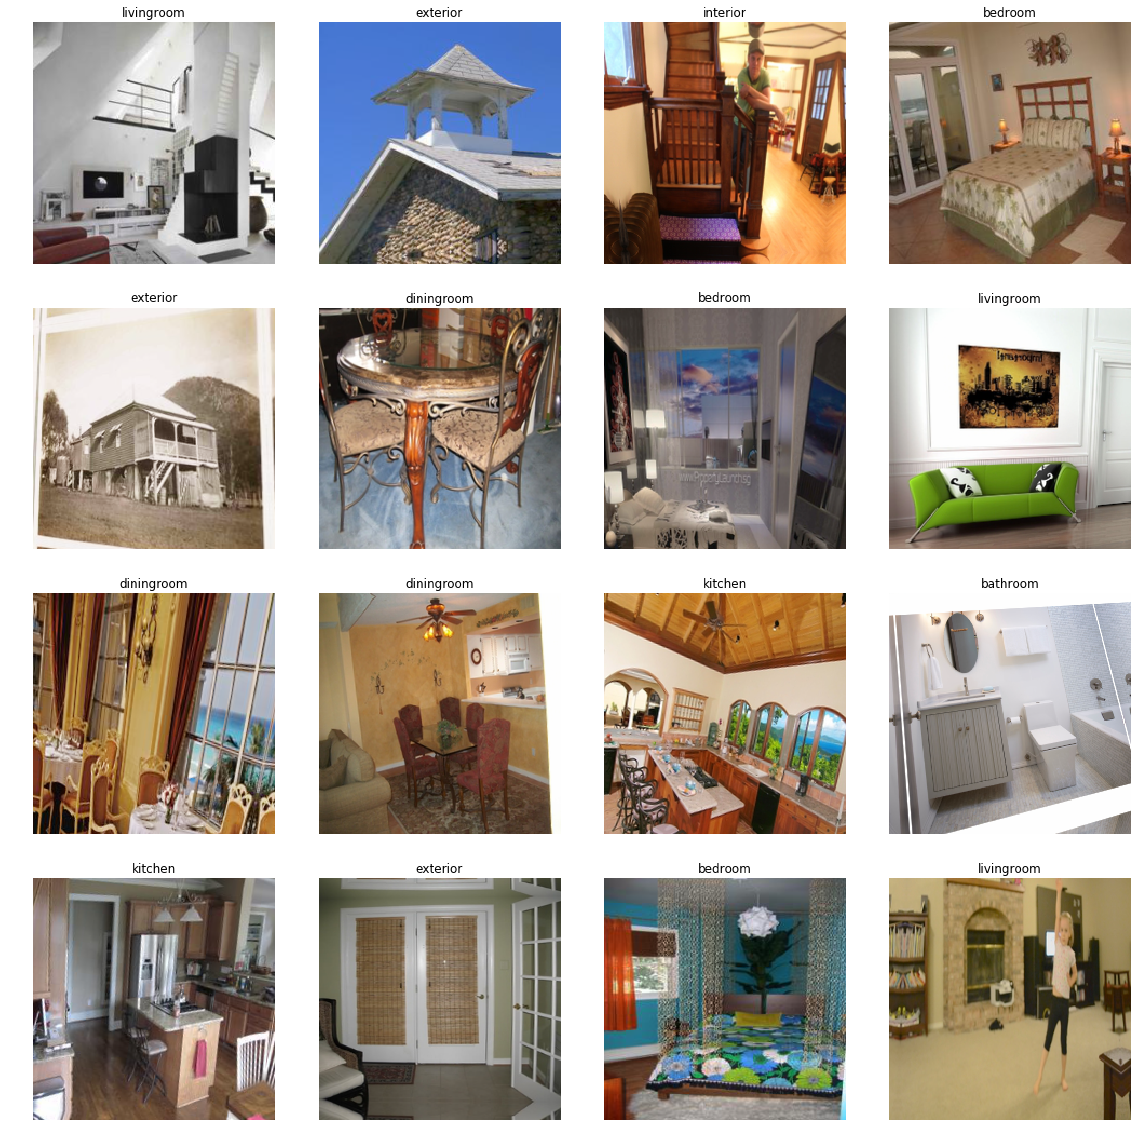

In [8]:
data.show_batch(rows=4)
plt.savefig("data/svgs/plotgallery.svg", format='svg')

# Train resnet34 model 

In [8]:
model = models.resnet34

In [9]:
learn = create_cnn(data, model, metrics=accuracy,callback_fns=ShowGraph )

## fit first 3 epochs heads for transfer learning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


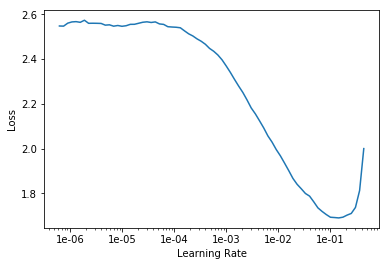

In [16]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,0.573611,0.475514,0.835387
2,0.485015,0.406726,0.858326
3,0.432973,0.390422,0.864019


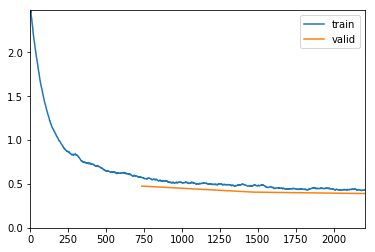

In [17]:
learn.fit_one_cycle(3)

In [18]:
learn.save('stage-1-rn34')

## transfer learning practice
After using transfer learning practice the model converges faster with better accuracy

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


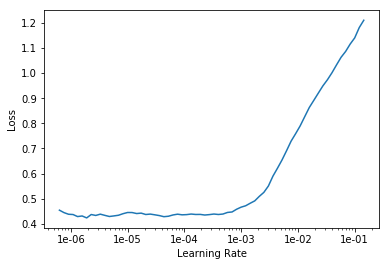

In [20]:
learn.lr_find()
learn.recorder.plot()

## choosing discriminative learning rates
discriminative learning rates allows to apply a different rate to each layer group
since the model is already converging we used less no of epochs

epoch,train_loss,valid_loss,accuracy
1,0.408161,0.362855,0.875956
2,0.372252,0.331446,0.887128
3,0.326311,0.304129,0.896814
4,0.274403,0.311171,0.893500
5,0.241602,0.293198,0.903483
6,0.200293,0.298576,0.902676
7,0.178443,0.296520,0.906415
8,0.148943,0.306831,0.906500
9,0.130741,0.311244,0.905947
10,0.128123,0.312017,0.906542


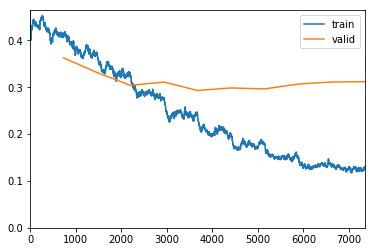

In [21]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3))

In [22]:
learn.save('stage-2-rn34')

# Interpretation

In [8]:
learn.load('stage-2-rn34');

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

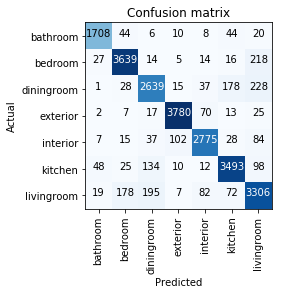

In [10]:
interp.plot_confusion_matrix()

In [30]:
preds1,y1,losses1 = learn.get_preds(with_loss=True)

In [34]:
interp1 = ClassificationInterpretation(data, preds1, y1, losses1)

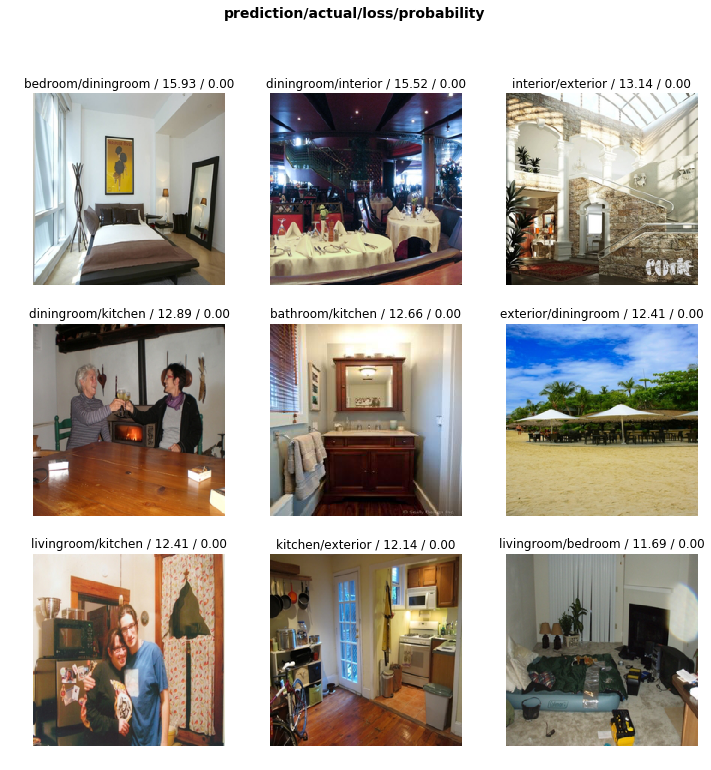

In [36]:
interp1.plot_top_losses(9)
plt.savefig("data/svgs/toplosses.svg", format='svg')

In [10]:
learn.load('realestate-rn34');

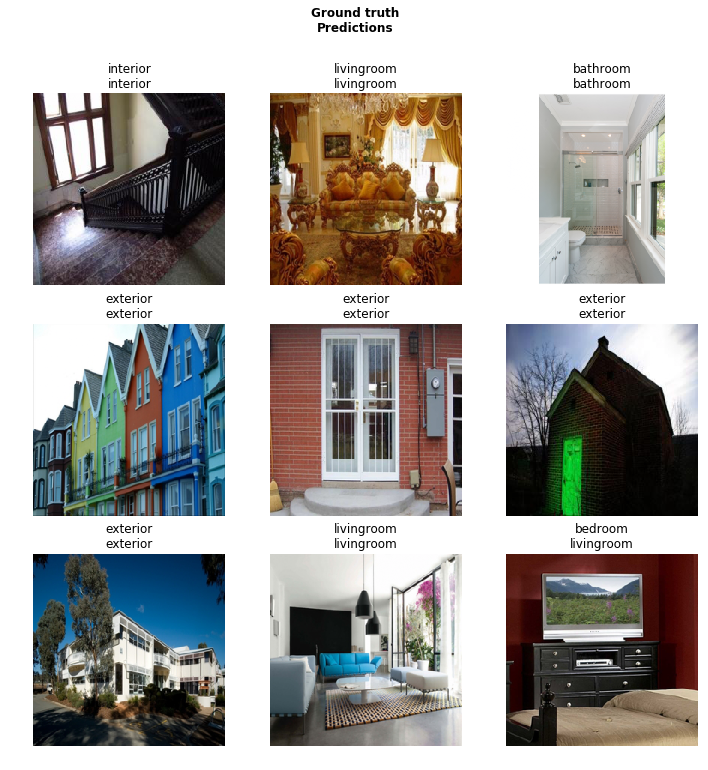

In [11]:
learn.show_results(rows=3)
plt.savefig("data/svgs/groundtruthprediction.svg", format='svg')

# Results

In [11]:
np.random.seed(42)
testdata = ImageItemList.from_folder(testpath)

In [28]:
preds,y = learn.get_preds(testdata)

In [38]:
accuracy(preds,y)

tensor(0.9747)

In [28]:
len(os.listdir(testpath)) 

29089

In [12]:
interp = learn.interpret(testdata)

In [37]:
interp.top_losses(9,largest=True)

(tensor([7.4708, 7.3217, 7.1429, 7.0965, 7.0426, 6.8533, 6.8229, 6.7979, 6.7957]),
 tensor([50257, 54207, 55584, 68336,   467, 67391, 67572, 77277, 24007]))

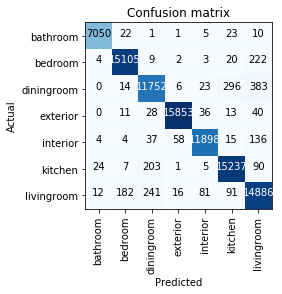

In [19]:
interp.plot_confusion_matrix()

In [20]:
interp.most_confused(min_val=50)

[('diningroom', 'livingroom', 383),
 ('diningroom', 'kitchen', 296),
 ('livingroom', 'diningroom', 241),
 ('bedroom', 'livingroom', 222),
 ('kitchen', 'diningroom', 203),
 ('livingroom', 'bedroom', 182),
 ('interior', 'livingroom', 136),
 ('livingroom', 'kitchen', 91),
 ('kitchen', 'livingroom', 90),
 ('livingroom', 'interior', 81),
 ('interior', 'exterior', 58)]

# Train resnet50 model

In [4]:
np.random.seed(42)
data1 = ImageDataBunch.from_folder(path, train='.',valid_pct=0.2, 
        ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [5]:
model = models.resnet50

In [6]:
learn = create_cnn(data1, model, metrics=accuracy,callback_fns=ShowGraph )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


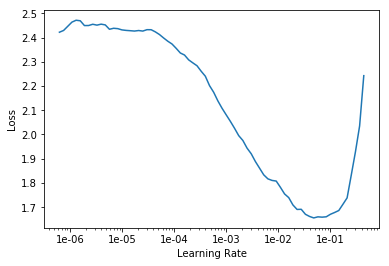

In [7]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,0.503577,0.410096,0.857222
2,0.390383,0.340103,0.883560
3,0.365164,0.326820,0.888828


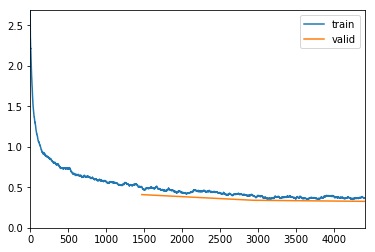

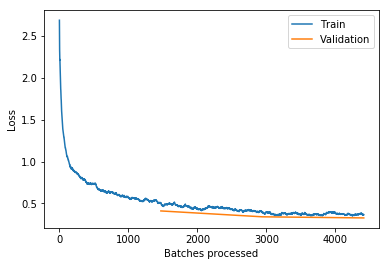

In [12]:
learn.fit_one_cycle(3)
learn.recorder.plot_losses()

In [13]:
learn.save('stage-1-rn50')

In [5]:
learn = create_cnn(data1, models.resnet50,metrics=accuracy,callback_fns=ShowGraph).load('stage-1-rn50');

In [6]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


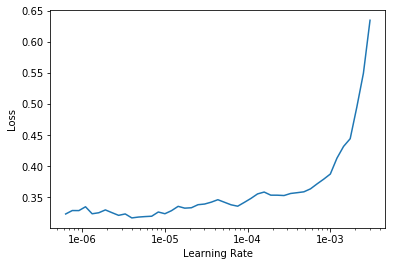

In [15]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,0.344766,0.315151,0.890697
2,0.323033,0.297061,0.897154
3,0.308937,0.280113,0.904248
4,0.251490,0.268511,0.908326
5,0.219256,0.278467,0.906839
6,0.182828,0.286964,0.907689
7,0.139376,0.279063,0.913084
8,0.119557,0.292150,0.912150
9,0.102578,0.296324,0.912999
10,0.091182,0.299941,0.912999


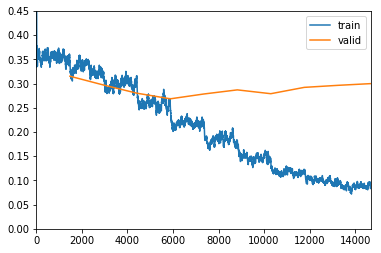

In [7]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3),wd=0.1)

In [8]:
learn.save('Classification-rn50',with_opt=False)

# Results

In [9]:
learn.load('Classification-rn50');

In [10]:
np.random.seed(42)
testdata = ImageItemList.from_folder(testpath)

In [11]:
random.shuffle(os.listdir(testpath))

In [12]:
preds,y,losses = learn.get_preds(testdata,with_loss=True)

In [13]:
accuracy(preds,y) 

tensor(0.9848)

# Interpretation

In [14]:
interp = learn.interpret(testdata)

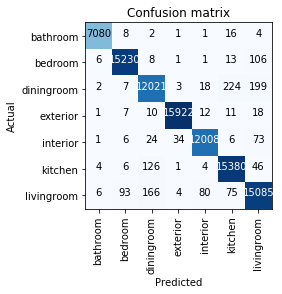

In [15]:
interp.plot_confusion_matrix()

In [16]:
interp.most_confused(min_val=50)

[('diningroom', 'kitchen', 224),
 ('diningroom', 'livingroom', 199),
 ('livingroom', 'diningroom', 166),
 ('kitchen', 'diningroom', 126),
 ('bedroom', 'livingroom', 106),
 ('livingroom', 'bedroom', 93),
 ('livingroom', 'interior', 80),
 ('livingroom', 'kitchen', 75),
 ('interior', 'livingroom', 73)]

## Objective Observation

1. resnet50 performs slightly better than resnet34.
2. we made sure the data distribution is even, split is random and relevent to label.
3. wd helped in regularizing the resnet50 network.
4. training errors were slightly less than validation erorrs in the acceptable range

# Next Steps

## Subjective Observation

1. Evaluate the projections
2. Comparing projections quality with Imagenet 

# Part 2 - Real Estate Attribute prediction model
## Finding richer attributes 